In [1]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, precision_recall_fscore_support
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cpu


In [4]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [5]:
#Dataloader

#Path for training and testing directory
train_path=r"C:\Users\aishu\Downloads\vidya\cnn custom\train"
test_path=r"C:\Users\aishu\Downloads\vidya\cnn custom\val"

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=64, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=64, shuffle=True
)

In [7]:
print(classes)

['Healthy_Image', 'Overnutrition_Image', 'Stunting_Image', 'Wasting_Image']


In [8]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=4):
        super(ConvNet,self).__init__()

        #Output size after convolution filter
        #((w-f+2P)/s) +1

        #Input shape= (256,3,150,150)

        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)

        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)


        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)


        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)



        #Feed forwad function

    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)

        output=self.pool(output)

        output=self.conv2(output)
        output=self.relu2(output)

        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)


            #Above output will be in matrix form, with shape (256,32,75,75)

        output=output.view(-1,32*75*75)


        output=self.fc(output)

        return output

In [9]:
model=ConvNet(num_classes=4).to(device)

In [10]:
#Optmizer and loss function
optimizer=Adam(model.parameters(),lr=0.0001,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [11]:
num_epochs=60

In [12]:
#calculating the size of training and testing images
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [13]:
print(train_count,test_count)

1995 501


In [24]:
def calculate_precision_recall(model, test_loader, loss_function):
    """Calculates precision, recall, true labels, and predicted labels for the given model and data loader.

    Args:
        model: The PyTorch model to evaluate.
        test_loader: The data loader for the test dataset.
        loss_function: The loss function used for training.

    Returns:
        precision: The precision, calculated as the ratio of true positives to all predicted positives.
        recall: The recall, calculated as the ratio of true positives to all actual positives.
        true_labels: True labels from the test dataset.
        predicted_labels: Predicted labels from the model.
    """

    model.eval()  # Set the model to evaluation mode

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = loss_function(outputs, labels)

            _, predicted = torch.max(outputs, 1)

            true_positives += (predicted == labels).sum().item()
            false_positives += ((predicted == 1) & (labels == 0)).sum().item()
            false_negatives += ((predicted == 0) & (labels == 1)).sum().item()

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)

    return precision, recall, true_labels, predicted_labels
best_accuracy = 0.0
for epoch in range(num_epochs):
    
   
    #Evaluation and training on training dataset
    model.train()
    train_accuracy=0.0
    train_loss=0.0

    for i, (images,labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        optimizer.zero_grad()

        outputs=model(images)
        loss=loss_function(outputs,labels)
        loss.backward()
        optimizer.step()


        train_loss+= loss.cpu().data*images.size(0)
        _,prediction=torch.max(outputs.data,1)

        train_accuracy+=int(torch.sum(prediction==labels.data))

    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count

     # Evaluation on testing dataset
    model.eval()

    test_accuracy=0.0
    precision, recall, _, _ = calculate_precision_recall(model, test_loader, loss_function)

    print('Epoch: ' + str(epoch) + ' Train Loss: ' + str(train_loss) +
          ' Train Accuracy: ' + str(train_accuracy) +
          ' Test Accuracy: ' + str(test_accuracy) +
          ' Precision: ' + str(precision) +
          ' Recall: ' + str(recall))
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())

        outputs=model(images)
        _,prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))

    test_accuracy=test_accuracy/test_count


    print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' Test Accuracy: '+str(test_accuracy))

    #Save the best model
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy  

Epoch: 0 Train Loss: tensor(0.0316) Train Accuracy: 0.9969924812030075 Test Accuracy: 0.0 Precision: 0.9556962025316456 Recall: 0.9320987654320988
Epoch: 0 Train Loss: tensor(0.0316) Train Accuracy: 0.9969924812030075 Test Accuracy: 0.6047904191616766
Epoch: 1 Train Loss: tensor(0.0424) Train Accuracy: 0.9954887218045113 Test Accuracy: 0.0 Precision: 0.9495268138801262 Recall: 0.940625
Epoch: 1 Train Loss: tensor(0.0424) Train Accuracy: 0.9954887218045113 Test Accuracy: 0.6007984031936128
Epoch: 2 Train Loss: tensor(0.0434) Train Accuracy: 0.9949874686716792 Test Accuracy: 0.0 Precision: 0.964968152866242 Recall: 0.9044776119402985
Epoch: 2 Train Loss: tensor(0.0434) Train Accuracy: 0.9949874686716792 Test Accuracy: 0.6087824351297405
Epoch: 3 Train Loss: tensor(0.0460) Train Accuracy: 0.9944862155388471 Test Accuracy: 0.0 Precision: 0.9732824427480916 Recall: 0.9659090909090909
Epoch: 3 Train Loss: tensor(0.0460) Train Accuracy: 0.9944862155388471 Test Accuracy: 0.5109780439121756
Epo

In [63]:
def train(model, train_loader, optimizer, loss_function):
    model.train()  # Set the model to training mode
    train_loss = 0.0
    train_accuracy = 0.0
    total_samples = 0

    for images, labels in train_loader:
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predictions = torch.max(outputs.data, 1)
        train_accuracy += (predictions == labels).sum().item()
        total_samples += labels.size(0)

    train_loss /= total_samples
    train_accuracy = (train_accuracy / total_samples) * 100

    return train_loss, train_accuracy

In [64]:
def validate(model, val_loader, loss_function):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_accuracy = 0.0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in val_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            loss = loss_function(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predictions = torch.max(outputs.data, 1)
            val_accuracy += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    val_loss /= total_samples
    val_accuracy = (val_accuracy / total_samples) * 100

    return val_loss, val_accuracy

In [31]:
from sklearn.metrics import classification_report

# Inside calculate_precision_recall function after calculating precision and recall:
true_labels = labels.cpu().numpy()  # Convert labels to numpy array
predicted_labels = prediction.cpu().numpy()  # Convert predictions to numpy array
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.63      0.92      0.75        13
           1       0.83      0.45      0.59        11
           2       0.54      0.78      0.64         9
           3       0.93      0.70      0.80        20

    accuracy                           0.72        53
   macro avg       0.73      0.71      0.69        53
weighted avg       0.77      0.72      0.72        53



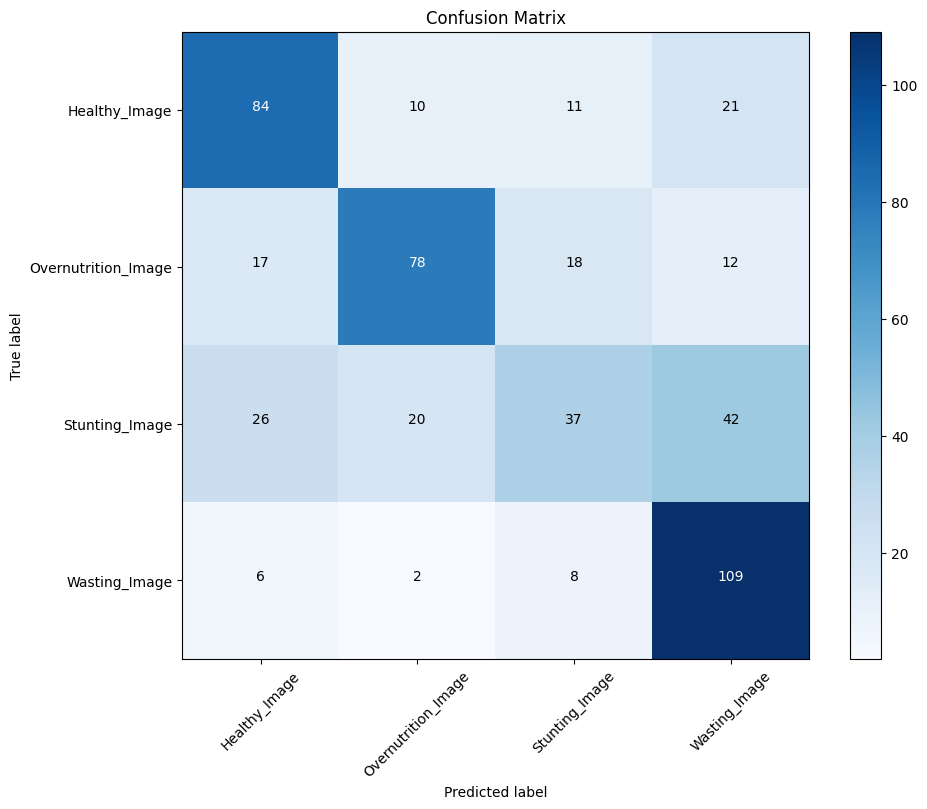

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader, classes):
    """Plots the confusion matrix for the given model and test data loader.

    Args:
        model: The PyTorch model to evaluate.
        test_loader: The data loader for the test dataset.
        classes: A list of class names.
    """
    model.eval()  # Set the model to evaluation mode

    y_true = []
    y_pred = []

    with torch.no_grad():  # Disable gradient calculation for efficiency
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = images.cuda()
                labels = labels.cuda()

            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
plot_confusion_matrix(model, test_loader, classes)

In [27]:
import matplotlib.pyplot as plt

def plot_training_validation(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plots the training and validation losses and accuracies.

    Args:
        train_losses: A list of training losses for each epoch.
        val_losses: A list of validation losses for each epoch.
        train_accuracies: A list of training accuracies for each epoch.
        val_accuracies: A list of validation accuracies for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Plot the losses
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'r', label='Training Loss')
    plt.plot(epochs, val_losses, 'b', label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot the accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()